# TM Data Strategist EDA Take Home

*Note: Functions are defined right before first use for quick reference. Can also be arranged together.

## 1 | Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import folium
from folium.plugins import HeatMap

plt.style.use('fivethirtyeight')

## 2 | Import Data

In [2]:
alerts_raw = pd.read_json('alerts-processed.json')
alerts_raw.head(2)

city  confidence country                           location  nThumbsUp  \
0  Taguig           0      RP  {'x': 121.051426, 'y': 14.550786}        0.0   
1  Taguig           0      RP  {'x': 121.051426, 'y': 14.550786}        0.0   

       pubMillis  reliability reportDescription  reportRating  \
0  1500025753030            5               NaN             1   
1  1500025753030            5               NaN             1   

         request_time  roadType   street            subtype type  \
0 2017-07-14 09:50:29       1.0  9th Ave  JAM_HEAVY_TRAFFIC  JAM   
1 2017-07-14 09:52:30       1.0  9th Ave  JAM_HEAVY_TRAFFIC  JAM   

                                   uuid  
0  0b36d5b7-e3e2-3a1f-9b28-59f28101882c  
1  0b36d5b7-e3e2-3a1f-9b28-59f28101882c

In [3]:
jams_raw = pd.read_json('jams-processed.json')
jams_raw.head(2)

blockingAlertUuid    city country  delay  endNode  length  level  \
0               NaN  Taguig      RP     99  9th Ave     200      3   
1               NaN  Taguig      RP     98  9th Ave     200      3   

                                                line      pubMillis  \
0  [{'x': 121.049383, 'y': 14.550538}, {'x': 121....  1499556154925   
1  [{'x': 121.049383, 'y': 14.550538}, {'x': 121....  1499556154925   

         request_time  roadType     speed startNode  street turnType  type  \
0 2017-07-08 23:22:39         1  1.433333       NaN  Lane O     NONE  NONE   
1 2017-07-08 23:24:39         1  1.447222       NaN  Lane O     NONE  NONE   

         uuid  
0  1213296112  
1  1213296112

## 3 | Data Cleaning

### 3.1 | Understanding the Data
Each record for 'alerts' is a user-reported event with time, location, and categorical events.  
Each record for 'jams' is real-time data of traffic jams.

In [4]:
print(f"There are {len(alerts_raw)} records for alerts.")
print(f"There are {len(jams_raw)} records for jams.")

There are 42737 records for alerts.
There are 58303 records for jams.


In [5]:
print(f"There are {alerts_raw['uuid'].nunique()} events for alerts.")
print(f"There are {jams_raw['uuid'].nunique()} events for jams.")

There are 2802 events for alerts.
There are 8922 events for jams.


In [6]:
print(f"There are {jams_raw['blockingAlertUuid'].nunique()} jam events matched with alert events.")

There are 8 jam events matched with alert events.


### Alerts Columns
 - **city: (string)** Taguig or Makati  
 - **confidence: (int)** derivative of 'reliability'  
 - **country: (string)** all RP  
 - **location: (dict)** coordinates x=lon, y=lat 
 - **nThumbsUp: (int)** variable for 'reliability' and 'confidence'  
 - **pubMillis: (int)** time of publication 
 - **reliability: (int)**  
 - **reportDescription: (string)** only 433 / 42,737 records have values  
 - **reportRating: (int)** variable for 'reliability'  
 - **request_time: (datetime)** extends over duration of event 
 - **roadType: (float)** 1.0, 2.0, 4.0, 6.0, 17.0, or 20.0; unclear what numbers map to  
 - **street: (string)**  
 - **subtype: (string)** many categories; 2,107 / 42,737 records are empty  
 - **type: (string)** JAM, WEATHERHAZARD, ACCIDENT, or ROAD_CLOSED  
 - **uuid: (string)** Waze groups alerts together  

### Jams Columns
 - **blockingAlertUuid: (string)** only 76 / 58,303 records have values; maps to 'Alerts' data  
 - **city: (string)** Taguig or Makati  
 - **country: (string)** all RP  
 - **delay: (int)** -1 to 7,101 seconds  
 - **endNode: (string)** 4,582 / 58,303 records are empty
 - **length: (int)** 25 to 6,666 meters
 - **level: (int)** 1, 2, 3, 4, or 5
 - **line: (array)** list of coordinates x=lon, y=lat 
 - **pubMillis: (int)** time of publication  
 - **request_time: (datetime)** extends over duration of event
 - **roadType: (int)** 1, 2, 4, or 6; unclear what numbers map to
 - **speed: (float)** 0 to 9.86 m/s
 - **startNode: (string)** only 2,406 / 58,303 records have values
 - **street: (string)**
 - **turnType: (string)** all NONE
 - **type: (string)** NONE, Small, Medium, Large, or Huge
 - **uuid: (int)** Waze groups traffic data together 


### 3.2 | Removing unnecessary data
#### Removed from Alerts Data
 - confidence
 - country
 - nThumbsUp
 - pubMillis
 - reportRating
 - roadType
 - reliability

#### Removed from Jams Data
 - country
 - endNode
 - pubMillis
 - startNode
 - turnType
 - roadType
 - type
 - speed

In [7]:
alerts_df = alerts_raw.drop(columns=['confidence', 'country', 'nThumbsUp', 'pubMillis', 'reportRating',
                                     'roadType', 'reliability'])
alerts_df.head(3)

city                           location reportDescription  \
0  Taguig  {'x': 121.051426, 'y': 14.550786}               NaN   
1  Taguig  {'x': 121.051426, 'y': 14.550786}               NaN   
2  Taguig  {'x': 121.051426, 'y': 14.550786}               NaN   

         request_time   street            subtype type  \
0 2017-07-14 09:50:29  9th Ave  JAM_HEAVY_TRAFFIC  JAM   
1 2017-07-14 09:52:30  9th Ave  JAM_HEAVY_TRAFFIC  JAM   
2 2017-07-14 09:54:31  9th Ave  JAM_HEAVY_TRAFFIC  JAM   

                                   uuid  
0  0b36d5b7-e3e2-3a1f-9b28-59f28101882c  
1  0b36d5b7-e3e2-3a1f-9b28-59f28101882c  
2  0b36d5b7-e3e2-3a1f-9b28-59f28101882c

In [8]:
jams_df = jams_raw.drop(columns=['country', 'endNode', 'pubMillis', 'startNode', 'turnType','roadType',
                                 'speed', 'type'])
jams_df.head(3)

blockingAlertUuid    city  delay  length  level  \
0               NaN  Taguig     99     200      3   
1               NaN  Taguig     98     200      3   
2               NaN  Taguig     97     200      3   

                                                line        request_time  \
0  [{'x': 121.049383, 'y': 14.550538}, {'x': 121.... 2017-07-08 23:22:39   
1  [{'x': 121.049383, 'y': 14.550538}, {'x': 121.... 2017-07-08 23:24:39   
2  [{'x': 121.049383, 'y': 14.550538}, {'x': 121.... 2017-07-08 23:26:40   

   street        uuid  
0  Lane O  1213296112  
1  Lane O  1213296112  
2  Lane O  1213296112

### 3.3 | Convert timezone to Manila (GMT+08:00)

In [9]:
def utc_to_tz(df, columns, tz):
    """
    Localizes datetime columns to UTC, then converts to specified timezone.
    """
    output_df = df.copy()
    output_df.loc[:,columns] = df.loc[:,columns].dt.tz_localize('UTC').dt.tz_convert(tz)
    return output_df

In [10]:
# Convert timezone
alerts_df = utc_to_tz(alerts_df, 'request_time', 'Asia/Manila')
jams_df = utc_to_tz(jams_df, 'request_time', 'Asia/Manila')

### 3.4 | Replace blank data in alerts_df['subtype'] with corresponding data from alerts_df['type']

The cause of blank spaces under the 'subtype' column is not certain, but could be due to the lack of subcategories under report type. Hence, it would be more informative to replace these blanks with their corresponding values in the 'type' column.

In [11]:
alerts_df['subtype'] = alerts_df['subtype'].replace(r'^\s*$', np.nan, regex=True)
alerts_df['subtype'] = alerts_df['subtype'].fillna(alerts_df['type'])

### 3.5 | Filter out data points in Makati and on C. P. Garcia (C-5)

C-5 (N and S) on Waze is preceded by '11: '

In [12]:
# Store a copy of all jams for later map visualization
jams_all = jams_df.copy()

In [13]:
def rm_startswith_df(df, rm_startswith, index=True, rm_col=None):
    if index:
        output_df = df[~df.index.str.startswith(rm_startswith)]
    if rm_col:
        output_df = df[~df[rm_col].str.startswith(rm_startswith, na=False)]
    return output_df

In [14]:
# Filter Alerts
alerts_df = rm_startswith_df(alerts_df, '11: ', index=False, rm_col='street')
alerts_df = rm_startswith_df(alerts_df, 'Makati', index=False, rm_col='city')

# Filter Jams
jams_df = rm_startswith_df(jams_df, '11: ', index=False, rm_col='street')
jams_df = rm_startswith_df(jams_df, 'Makati', index=False, rm_col='city')

In [15]:
print(f"There are {len(alerts_df)} records for alerts.")
print(f"There are {len(jams_df)} records for jams.")

There are 34582 records for alerts.
There are 45546 records for jams.


In [16]:
print(f"There are {alerts_df['uuid'].nunique()} events for alerts.")
print(f"There are {jams_df['uuid'].nunique()} events for jams.")

There are 2275 events for alerts.
There are 7547 events for jams.


### 3.6 | Consolidate Alert Events and Jam Events

In [17]:
def combine_alerts_gb(gb_obj):
    """
    Aggregating function to facilitate GroupBy of Alert Events by uuid.
    """
    d = {}
    d['location'] = gb_obj['location'].iloc[0]
    d['type'] = gb_obj['subtype'].iloc[0]
    d['description'] = gb_obj['reportDescription'].iloc[0]
    d['start_time'] = gb_obj['request_time'].min()
    d['end_time'] = gb_obj['request_time'].max()
    d['duration'] = gb_obj['request_time'].max() - gb_obj['request_time'].min()
    return pd.Series(d)

def combine_jams_gb(gb_obj):
    """
    Aggregating function to facilitate GroupBy of Jam Events by uuid.
    """
    d = {}
    d['alert_uuid'] = gb_obj['blockingAlertUuid'].iloc[0]
    d['delay_max'] = gb_obj['delay'].max()
    d['delay_min'] = gb_obj['delay'].min()
    d['delay_mean'] = gb_obj['delay'].mean()
    d['length_max'] = gb_obj['length'].max()
    d['length_min'] = gb_obj['length'].min()
    d['length_mean'] = gb_obj['length'].mean()
    d['level_max'] = gb_obj['level'].max()
    d['level_min'] = gb_obj['level'].min()
    d['level_mean'] = gb_obj['level'].mean()
    d['line'] = gb_obj['line'].iloc[0]
    d['start_time'] = gb_obj['request_time'].min()
    d['end_time'] = gb_obj['request_time'].max()
    d['duration'] = gb_obj['request_time'].max() - gb_obj['request_time'].min()
    return pd.Series(d)

In [18]:
# Consolidate Alert Events
alert_events = alerts_df.groupby('uuid').apply(combine_alerts_gb)
alert_events.head(3)

location  \
uuid                                                                      
00155599-0ff9-3fb5-ba30-00a10a826a26  {'x': 121.049606, 'y': 14.555791}   
002de12d-b906-3aa9-883f-9c08da33a3ec  {'x': 121.049108, 'y': 14.555633}   
004f2061-e918-35b8-a44c-d2fbec95c9c1  {'x': 121.048892, 'y': 14.552288}   

                                                         type description  \
uuid                                                                        
00155599-0ff9-3fb5-ba30-00a10a826a26        JAM_HEAVY_TRAFFIC         NaN   
002de12d-b906-3aa9-883f-9c08da33a3ec        JAM_HEAVY_TRAFFIC         NaN   
004f2061-e918-35b8-a44c-d2fbec95c9c1  JAM_STAND_STILL_TRAFFIC         NaN   

                                                    start_time  \
uuid                                                             
00155599-0ff9-3fb5-ba30-00a10a826a26 2017-07-13 19:13:32+08:00   
002de12d-b906-3aa9-883f-9c08da33a3ec 2017-07-14 11:09:28+08:00   
004f2061-e918-35b8-a44c-d2fbec95c9c1 2017-07-10 17:25:40+08:00   

                                                      end_time duration  
uuid                                                                     
00155599-0ff9-3fb5-ba30-00a10a826a26 2017-07-13 19:37:44+08:00 00:24:12  
002de12d-b906-3aa9-883f-9c08da33a3ec 2017-07-14 11:37:43+08:00 00:28:15  
004f2061-e918-35b8-a44c-d2fbec95c9c1 2017-07-10 17:53:54+08:00 00:28:14

In [19]:
# Consolidate Jam Events
jam_events = jams_df.groupby('uuid').apply(combine_jams_gb)
jam_events.head(3)

alert_uuid  delay_max  delay_min  delay_mean  length_max  \
uuid                                                                  
1189003272        NaN         79         60       73.75         202   
1190321993        NaN         70         70       70.00         299   
1191567163        NaN         61         61       61.00         311   

            length_min  length_mean  level_max  level_min  level_mean  \
uuid                                                                    
1189003272         202        202.0          1          1         1.0   
1190321993         299        299.0          2          2         2.0   
1191567163         311        311.0          3          3         3.0   

                                                         line  \
uuid                                                            
1189003272  [{'x': 121.048503, 'y': 14.547921}, {'x': 121....   
1190321993  [{'x': 121.052775, 'y': 14.557546}, {'x': 121....   
1191567163  [{'x': 121.053293, 'y': 14.55632}, {'x': 121.0...   

                          start_time                  end_time duration  
uuid                                                                     
1189003272 2017-07-09 00:00:52+08:00 2017-07-09 00:06:54+08:00 00:06:02  
1190321993 2017-07-09 00:43:02+08:00 2017-07-09 00:43:02+08:00 00:00:00  
1191567163 2017-07-09 01:05:08+08:00 2017-07-09 01:05:08+08:00 00:00:00

In [20]:
# Consolidate jams_all for later map visualization
jam_events_all = jams_all.groupby('uuid').apply(combine_jams_gb)

### 3.7 | Remove jam events with only one data point

In [21]:
jam_events = jam_events[jam_events['duration'].dt.seconds > 0]
jam_events.head(3)

alert_uuid  delay_max  delay_min  \
uuid                                                                     
1189003272                                   NaN         79         60   
1192252404  3e479d77-1cf6-33bb-a411-05d4e8555103         -1         -1   
1192391927                                   NaN         90         89   

            delay_mean  length_max  length_min  length_mean  level_max  \
uuid                                                                     
1189003272       73.75         202         202        202.0          1   
1192252404       -1.00          67          67         67.0          5   
1192391927       89.50         191         191        191.0          3   

            level_min  level_mean  \
uuid                                
1189003272          1         1.0   
1192252404          5         5.0   
1192391927          3         3.0   

                                                         line  \
uuid                                                            
1189003272  [{'x': 121.048503, 'y': 14.547921}, {'x': 121....   
1192252404  [{'x': 121.054569, 'y': 14.554217}, {'x': 121....   
1192391927  [{'x': 121.046036, 'y': 14.549297}, {'x': 121....   

                          start_time                  end_time duration  
uuid                                                                     
1189003272 2017-07-09 00:00:52+08:00 2017-07-09 00:06:54+08:00 00:06:02  
1192252404 2017-07-09 00:00:52+08:00 2017-07-09 00:22:58+08:00 00:22:06  
1192391927 2017-07-09 00:00:52+08:00 2017-07-09 00:02:53+08:00 00:02:01

In [22]:
print(f"After removing single-record events (duration of 0 seconds), {len(jam_events)} jam events remain.")

After removing single-record events (duration of 0 seconds), 4233 jam events remain.


## 4 | EDA

### 4.1 | Understanding Temporal Traffic Patterns

#### Per Day of the Week

In [23]:
def plot_scatter_radius_color(x, y, z, c, colormap, day_desc, cmap_ticklabels=None):
    """
    Scatterplot with 2 additional dimensions: bubble radius (z) and color (c)
    """
    xmin = pd.to_datetime(['00:00:00']).time[0]
    xmax = pd.to_datetime(['23:59:59']).time[0]
    ymin = 0
    ymax = 4000
    cmap = plt.cm.get_cmap(colormap, 5)
    xticks = pd.to_datetime(['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','23:59:59']).time
    xtick_labels = ['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','24:00']

    fig = plt.figure(figsize=(10,6))
    ax = fig.gca()
    sc = ax.scatter(x,y,s=z/10,c=c,alpha=0.3,cmap=cmap,zorder=2)
    sc.set_clim([1-0.5,5+0.5])
    cb = fig.colorbar(sc,pad=0.03)
    cb.set_label('Traffic Congestion Level', fontsize=16)
    if day_desc == 'Weekday':
        cb.set_label('Day of Week', fontsize=16)
    if cmap_ticklabels:
        cb.ax.set_yticklabels(cmap_ticklabels)

    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)

    plt.title(f'Traffic Data on {day_desc}', fontsize=16)
    plt.xlabel('Request Time', fontsize=16)
    plt.ylabel('Delay [s]', fontsize=16)
    plt.grid(which='both',axis='both',linewidth=0.25,zorder=1)
    plt.xticks(ticks=xticks, labels=xtick_labels, rotation=30,rotation_mode='anchor',ha='right',fontsize=10)

    l1 = plt.scatter([],[], s=50, facecolors=[0.5,0.5,0.5])
    l2 = plt.scatter([],[], s=100, facecolors=[0.5,0.5,0.5])
    l3 = plt.scatter([],[], s=200, facecolors=[0.5,0.5,0.5])

    labels = ["500m", "1,000m", "2,000m"]

    leg = plt.legend([l1, l2, l3], labels, ncol=1, frameon=True, fontsize=14,
                     loc=2, borderpad=1, handletextpad=1,title='Traffic Jam Length')
    
    plt.show()
    
def get_hour_minute(df, time_col):
    """
    Obtain plottable time data from datetime column of a DataFrame.
    """
    time_series = pd.to_datetime(list(df[time_col])).time
    return time_series

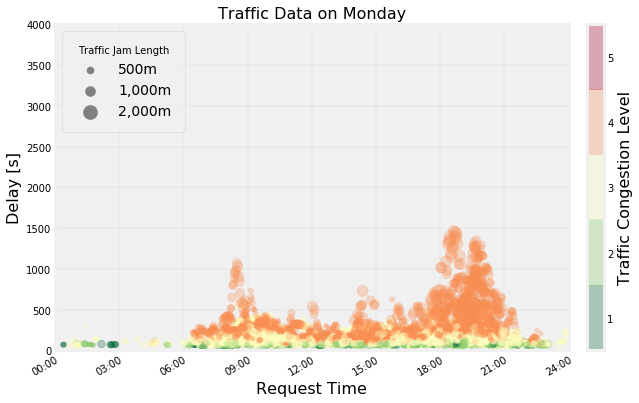

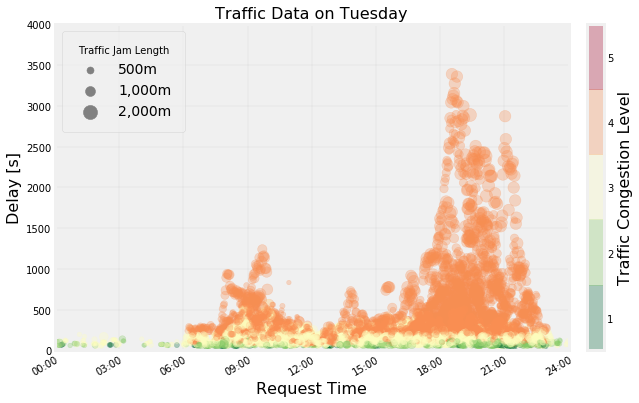

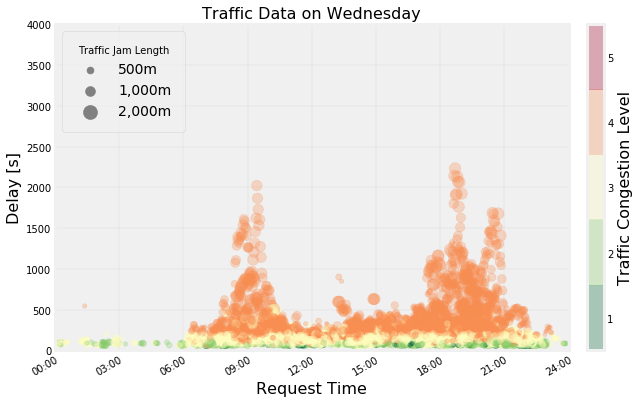

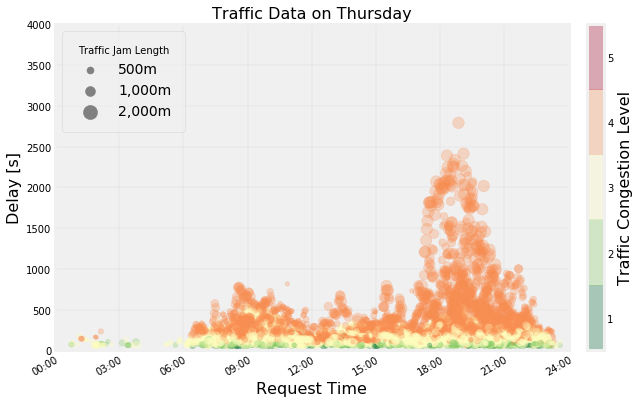

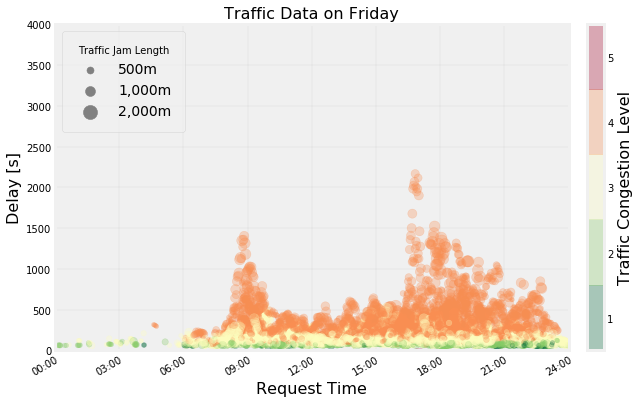

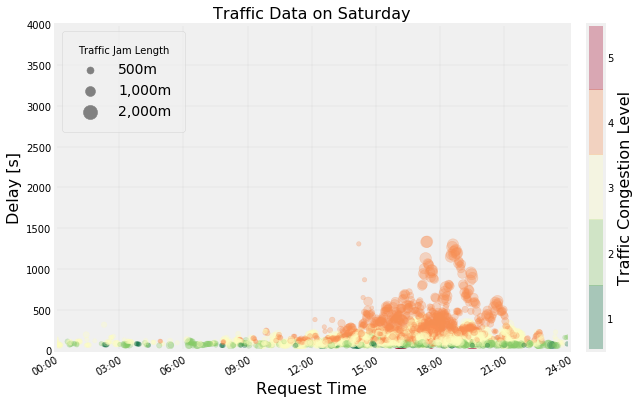

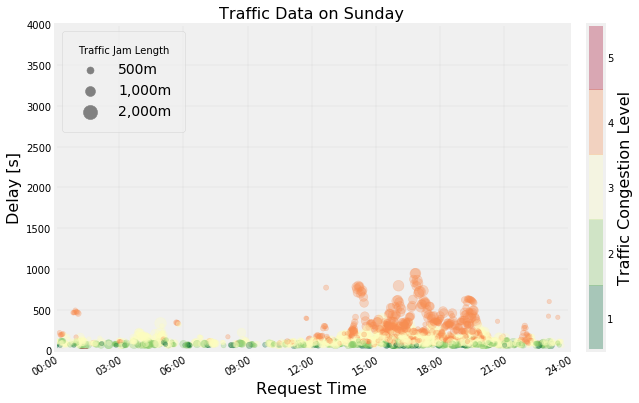

In [24]:
# Get day of week for each datapoint
jams_dayofweek = jams_df['request_time'].dt.dayofweek

for day in range(7):
    # Jam data points for specific day of week
    jams_day_df = jams_df[jams_dayofweek == day]
    
    # Prepare data for scatter plot
    x = get_hour_minute(jams_day_df, 'request_time')
    y = jams_day_df['delay']
    z = jams_day_df['length']
    c = jams_day_df['level']
    day = jams_day_df['request_time'].iloc[0].day_name()
    
    # Scatter Plot
    plot_scatter_radius_color(x, y, z, c, colormap='RdYlGn_r', day_desc=day)

#### Aggregated Weekday

In [25]:
def get_daysofweek_df(df, dt_column, days):
    """
    Filter DataFrame based on Day-of-Week of specified Datetime column.
    """
    dayofweek = df[dt_column].dt.dayofweek
    output_df = df.copy()
    output_df = df[dayofweek.isin(days)]
    return output_df

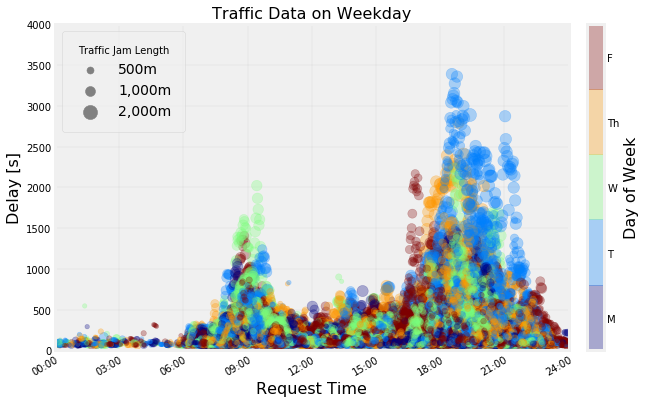

In [26]:
# Jam data points during weekdays
jams_wd_df = get_daysofweek_df(jams_df, 'request_time', range(5))

# Prepare data for scatter plot
x = get_hour_minute(jams_wd_df, 'request_time')
y = jams_wd_df['delay']
z = jams_wd_df['length']
c = jams_wd_df['request_time'].dt.dayofweek + 1
day = 'Weekday'

# Scatter Plot
plot_scatter_radius_color(x, y, z, c, colormap='jet', day_desc=day, cmap_ticklabels=['M','T','W','Th','F'])

### 4.2 | Understanding Traffic Causes

In [27]:
def get_distribution_and_cdf(df, rm_startswith=None):
    """
    Process the data to obtain distribution of total event time and cumulative percentage per event type.
    Start and end indicate the range of categories to be used in descending order.
    """
    output_df = df.groupby('type').sum()
    output_df['duration'] = output_df['duration'].dt.days * 24 + output_df['duration'].dt.seconds / 3600
    if rm_startswith:
        output_df = rm_startswith_df(output_df, rm_startswith)
    output_df = output_df.sort_values(by='duration',ascending=False)
    output_df['perc'] = output_df['duration']/output_df['duration'].sum()*100
    output_df['cdf'] = output_df['duration'].cumsum()/output_df['duration'].sum()*100
    return output_df

def plot_pareto(labels, count, cdf, data_desc, unit_desc, add_desc=''):
    """
    Plots a Pareto Chart with 2 Y-axes.
    """
    fig, ax1 = plt.subplots(figsize=(12,8))

    color = 'tab:red'
    ax1.set_ylabel(f'{unit_desc}', color=color)
    ax1.set_xlabel(data_desc)
    ax1.bar(labels, count, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticklabels(labels, rotation=45, rotation_mode='anchor', ha='right', fontsize=10)

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('Cumulative Percentage', color=color)
    ax2.plot(labels, cdf, color=color, marker="o", ms=6)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0)

    plt.title(f'Distribution of {unit_desc} {add_desc}')

    plt.show()

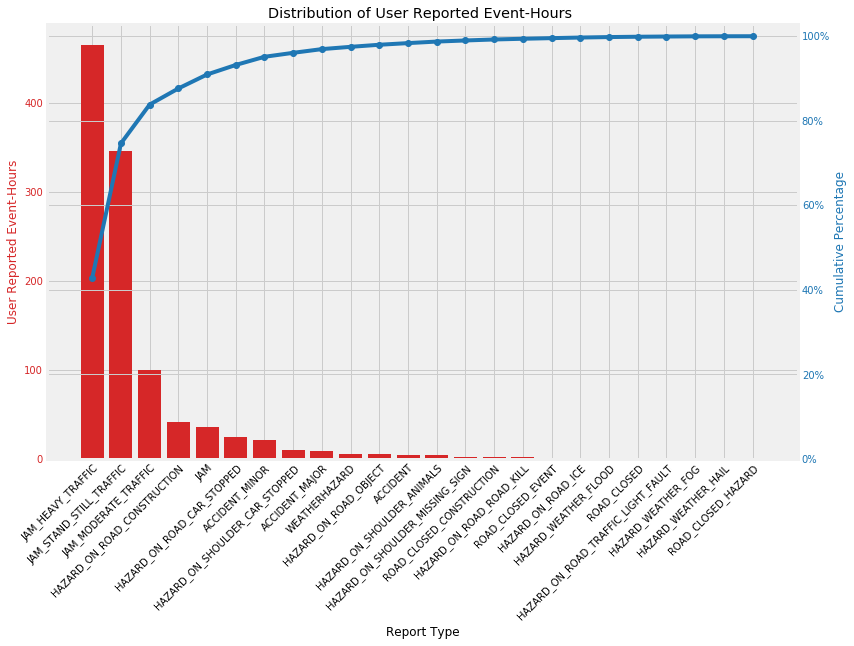

In [28]:
# Prepare data for Pareto Chart
pareto_df = get_distribution_and_cdf(alert_events)

# Plot Pareto Chart
plot_pareto(pareto_df.index, pareto_df['duration'], pareto_df['cdf'], data_desc='Report Type', unit_desc='User Reported Event-Hours')

#### Distribution for Weekday PM Peak (16:00 - 22:00) w/o Traffic Jam Reports

In [29]:
def get_peak_df(df, start, end):
    """
    Filter DataFrame based on range of time of day.
    """
    peak_start = pd.to_datetime([start]).time[0]
    peak_end = pd.to_datetime([end]).time[0]
    start_time = df['start_time'].dt.time
    end_time = df['end_time'].dt.time
    cond1 = (start_time <= peak_start) & (end_time >= peak_start)
    cond2 = (start_time >= peak_start) & (start_time <= peak_end)
    output_df = df[cond1 | cond2]
    return output_df

In [30]:
# Alert Events for Weekday PM Peak
alert_events_wd = get_daysofweek_df(alert_events, 'start_time', range(5))
alert_events_wd_pm = get_peak_df(alert_events_wd, '16:00:00', '22:00:00')

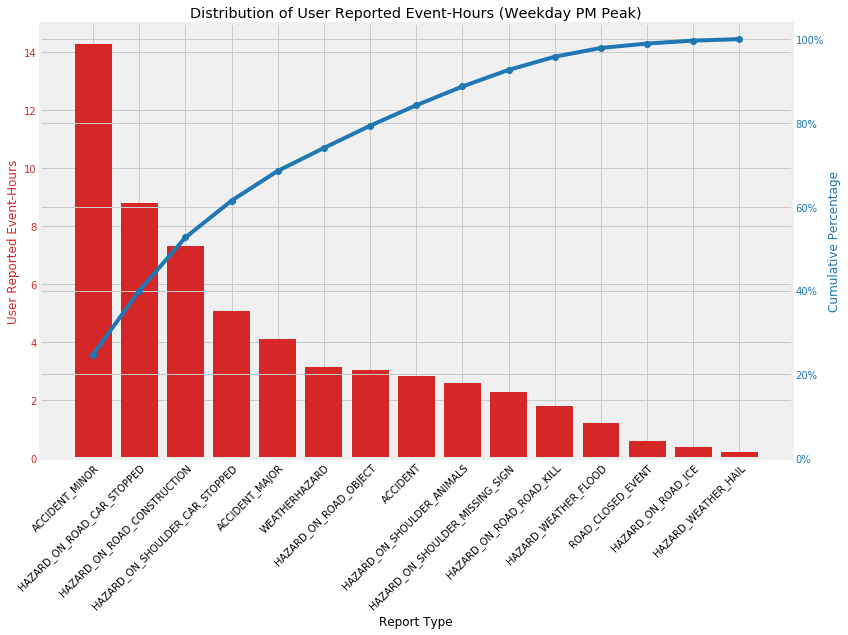

In [31]:
# Prepare data for Pareto Chart
pareto_pm_df = get_distribution_and_cdf(alert_events_wd_pm, rm_startswith='JAM')

# Plot Pareto Chart
plot_pareto(pareto_pm_df.index, pareto_pm_df['duration'], pareto_pm_df['cdf'],
            data_desc='Report Type', unit_desc='User Reported Event-Hours', add_desc='(Weekday PM Peak)')

In [32]:
# Show values
pareto_pm_df

duration       perc         cdf
type                                                             
ACCIDENT_MINOR                   14.281667  24.743131   24.743131
HAZARD_ON_ROAD_CAR_STOPPED        8.799167  15.244645   39.987776
HAZARD_ON_ROAD_CONSTRUCTION       7.326389  12.693043   52.680819
HAZARD_ON_SHOULDER_CAR_STOPPED    5.072222   8.787676   61.468495
ACCIDENT_MAJOR                    4.099722   7.102810   68.571305
WEATHERHAZARD                     3.155278   5.466551   74.037855
HAZARD_ON_ROAD_OBJECT             3.060278   5.301962   79.339817
ACCIDENT                          2.822778   4.890491   84.230308
HAZARD_ON_SHOULDER_ANIMALS        2.585833   4.479982   88.710291
HAZARD_ON_SHOULDER_MISSING_SIGN   2.281944   3.953492   92.663782
HAZARD_ON_ROAD_ROAD_KILL          1.814167   3.143062   95.806844
HAZARD_WEATHER_FLOOD              1.210278   2.096818   97.903663
ROAD_CLOSED_EVENT                 0.604444   1.047206   98.950869
HAZARD_ON_ROAD_ICE                0.403889   0.699742   99.650610
HAZARD_WEATHER_HAIL               0.201667   0.349390  100.000000

### 4.3 | Understanding Geospatial Traffic Patterns

In [35]:
def plot_on_map(df_alerts, df_jams=None, mapmode='markermap'):
    
    # Establish map location
    midpoint = [14.550620, 121.050666]
    m = folium.Map(location=midpoint, tiles='cartodbpositron', zoom_start=16)
    folium.Circle(location=midpoint,
                  radius=1000, 
                  popup='Bonifacio High Street', 
                  color='#3186cc', 
                  fill=True, 
                  fill_color='#3186cc').add_to(m)
    
    # Alert types actionable by LGU
    action_types = ['HAZARD_ON_ROAD_CAR_STOPPED', 'ACCIDENT_MINOR',
       'HAZARD_ON_SHOULDER_CAR_STOPPED', 'ACCIDENT_MAJOR', 'HAZARD_ON_ROAD_OBJECT',
       'HAZARD_ON_SHOULDER_MISSING_SIGN', 'HAZARD_ON_ROAD_ROAD_KILL', 'HAZARD_ON_SHOULDER_ANIMALS', 'ACCIDENT']
    
    if mapmode == 'markermap':
        # Map Jam Events as lines
        if df_jams is not None:
            for uuid, jam_event in df_jams.iterrows():
                line_data = [(point['y'], point['x']) for point in jam_event['line']]
                folium.features.PolyLine(line_data,color='red',weight=5,opacity=0.05).add_to(m)
                
        # Map Alert Events as circles
        if df_alerts is not None:
            for uuid, alert in df_alerts.iterrows():
                mcolor = 'blue'
                if alert['type'] in action_types:
                    mcolor = 'yellow'
                folium.Circle(location=(alert['location']['y'], alert['location']['x']),
                              popup=alert['type'],
                              color=mcolor, fill_color=mcolor, radius=10).add_to(m)
                
#     --- HEATMAP UNUSED ---
#     if mapmode == 'heatmap':
#         if df_alerts is not None:
#             hm_data = [(event['location']['y'], event['location']['x'], event['duration'].seconds) \
#                          for uuid, event in df_alerts.iterrows()]
#             HeatMap(hm_data,radius=10).add_to(m)
#         if df_jams is not None:
#             hm_data = []
#             for uuid, jam_event in df_jams.iterrows():
#                 hm_data += [(point['y'], point['x'], jam_event['level_mean']) for point in jam_event['line']]
#             HeatMap(hm_data,radius=10).add_to(m)
            
    return m

#### Map of Alerts and Jams per Day

For better visualizaton, jam_events from Makati and on C-5 can also be viewed.

In [37]:
m_day = []

for day in range(5):
    # PM Peak Alerts for Specific Day (except jams)
    alert_events_day_pm = get_daysofweek_df(alert_events_wd_pm, 'start_time', [day])
    alert_events_day_pm_nojam = rm_startswith_df(alert_events_day_pm, 'JAM', index=False, rm_col='type')
    
    # PM Peak Jams for Specific Day (including Makati and C-5 for visualization)
    jam_events_day = get_daysofweek_df(jam_events_all, 'start_time', [day])
    jam_events_day_pm = get_peak_df(jam_events_day, '16:00:00', '22:00:00')
    
    # Store maps
    m_day.append( plot_on_map(alert_events_day_pm_nojam, jam_events_day_pm, mapmode='markermap') )

In [46]:
# Monday
m_day[0]

In [47]:
# Tuesday
m_day[1]

In [48]:
# Wednesday
m_day[2]

In [49]:
# Thursday
m_day[3]

In [50]:
# Friday
m_day[4]

In [51]:
# All Weekday PM Peak Alerts (except jams)
alert_events_wd_pm_nojam = rm_startswith_df(alert_events_wd_pm, 'JAM', index=False, rm_col='type')
alert_events_wd_pm_nojam = get_peak_df(alert_events_wd_pm_nojam, '16:00:00', '22:00:00')

# All Weekday PM Peak Jams (including Makati and C-5 for visualization)
jam_events_wd = get_daysofweek_df(jam_events_all, 'start_time', range(5))
jam_events_wd_pm = get_peak_df(jam_events_wd, '17:00:00', '20:00:00') # Reduced range to help load map (visualization purpose only)

#### Map of Alerts and Jams on Aggregate (Weekday PM Peak)

In [52]:
plot_on_map(alert_events_wd_pm_nojam, jam_events_wd_pm, mapmode='markermap')

## 5 | Miscellaneous Investigation

Checking detailed report descriptions

In [67]:
alert_events['description'].unique()

array([nan, 'Earthquake drill @ bgc ongoing ',
       "F this BS. WHY CANT YA'LL JUST STAY HOME. 🙄", 'NS 3219 GAGO KA',
       'A tree fell on a car causing buildup along 26th st cor 7th ave BGC',
       'Hhaaaayy', '*** inAng hoop yan..rush our iisa.',
       'Konting ulan traffic! 😡😡😡', 'putaaaaaaaah!!!??!!!!', 'UGHHHHHHH',
       'D@mn it', 'left side srvc rd', '3-car collision ',
       'malas nman nya nabagsakan ng puno', '13 pa',
       'change work nalang. Lugosi negosyo', 'gutom nako!!',
       'At the corner of 30th and 5th', 'papunta kalayaan',
       'blocked intersection', 'puta', 'bgc', 'puta!!!!?',
       'Broken motorcycle'], dtype=object)

The one about a tree falling is particularly interesting.

In [73]:
tree_fall = alert_events[alert_events['description'] == 'malas nman nya nabagsakan ng puno']

In [74]:
plot_on_map(tree_fall, mapmode='markermap')